<a href="https://colab.research.google.com/github/eliasboughosn/MIMIC-ML-algorithms/blob/main/ml_algorithms_BOUGHOSN_elias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Course: Machine Learning Algorithms
## by Elias Boughosn

## 0. Table of Content

1. **Introduction**

    a. Introduction
    
    b. Library imports and built functions


2. **Data pre-processing**
    
    a. Handling missing values

    b. removing dead patients

    c. handling TEXT variable
    
    d. choosing our target variable and features
    
    e. transforming non numerical data to categorical
   
   
3. **Implementation of models**

    a. Random Forest
    
    b. Decision Tree
    
    c. Naive Bayes
    
    d. Logistic Regression

    e. knn

    f. SVM

    g. Boosting
4. **Evaluation metrics**

5. **Classification reports**

6. **Confusion Matrices**
 
7. **Conclusion**


# 1. Introduction
## Some explaination about columns

* Key
    * **SUBJECT_ID**
    * **HADM_ID**
 
* Patient 
    * **DOB:** Date of Birth
    * **GENDER**
    * **MARITAL_STATUS**
    * **ETHNICITY**
    * **INSURANCE**
    * **DEATHTIME:** Date of Death (if the patient has died)

* Admission
    * **ADMITTIME:** date of the admission
    * **ADMISSION_TYPE:** type of the admission
    * **DIAGNOSIS:** diagnosis made on admission
    * **['blood', 'circulatory', 'congenital', 'digestive',
       'endocrine', 'genitourinary', 'infectious', 'injury', 'mental', 'misc',
       'muscular', 'neoplasms', 'nervous', 'pregnancy', 'prenatal',
       'respiratory', 'skin']:** bag of word representation of DIAGNOSIS

* Discharge
    * **DISCHTIME:** date of the discharge
    * **DISCHARGE_LOCATION:** patient's destination after discharge from hospital
    * **TEXT:**discharge medical report

* Readmission
    * **DAYS_NEXT_ADMIT:** number of day beetween discharge and readmission
    * **NEXT_ADMITTIME:** date of the readmission
    * **OUTPUT_LABEL:** 0 if the patient has not been re-admitted / 1 if the patient has been re-admitted

**warning** : Data leakage has to be handled.

*   **what is data leakage?** : 

 Data leakage occurs when there is information about the target in the training data, but when the model is used for prediction, related data will not be usable. This results in high performance (and probably even validation data) on the training set, but the model would perform poorly in development.

# 2. Library imports and built functions

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier,  GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, roc_curve, auc
from sklearn.tree import DecisionTreeRegressor, plot_tree, DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report
from yellowbrick.classifier import ConfusionMatrix
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC 
from matplotlib.legend_handler import HandlerLine2D



import matplotlib.pyplot as plt
import numpy as np
import random as rd
import pandas as pd
import datetime as dt
import nltk 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
def remove_stop_words(tokenized_sentence):
    """
    Removes the stop words from a tokenized sentence  
    """
    punctuation = [".", ",", "[", "]", "`", "(", ")", "?", "'", "'s", ":", "!"]
    stop_words = stopwords.words('english')
    stop_words += punctuation
    return [w for w in tokenized_sentence if w not in stop_words]
    
def lemmatize(tokenized_sentence):
    """
    Create a lemmatizer object and lematized tokenized items (e.g. sentences)
    Might require running the following:
        nltk.download('wordnet')
    """
    lemmatizer = nltk.WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in tokenized_sentence]

sentence_processing = lambda sentence: " ".join(
    lemmatize(
        remove_stop_words(
            word_tokenize(str.lower(str(sentence)))
        )
    )
)

# 3. Data pre-processing

## importing our Data

In [ ]:
df_train = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/MIMIC-III-readmission/train.csv.zip")
df_test = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/MIMIC-III-readmission/test.csv.zip")
df_train.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DAYS_NEXT_ADMIT,NEXT_ADMITTIME,ADMISSION_TYPE,DEATHTIME,DISCHARGE_LOCATION,INSURANCE,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,TEXT,GENDER,DOB,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,OUTPUT_LABEL
0,937,148592,2163-01-20 18:39:00,2163-01-24 08:00:00,0.061806,2163-01-24 09:29:00,EMERGENCY,2163-01-26 08:00:00,DEAD/EXPIRED,Medicare,NaN,OTHER/UNKNOWN,INTRACRANIAL HEMORRHAGE,Admission Date: [**2163-1-20**] ...,M,2087-09-24 00:00:00,0,4,0,0,1,0,0,2,0,0,0,0,1,0,0,0,0,1
1,3016,159142,2107-01-23 02:45:00,2107-01-26 14:00:00,NaN,NaN,EMERGENCY,NaN,HOME HEALTH CARE,Medicare,MARRIED,WHITE,GASTROINTESTINAL BLEED,Admission Date: [**2107-1-23**] Discharge...,M,2028-04-07 00:00:00,0,2,0,2,1,0,0,1,2,0,0,0,0,0,0,1,0,0
2,2187,186282,2134-06-24 23:30:00,2134-07-02 17:45:00,NaN,NaN,EMERGENCY,NaN,REHAB/DISTINCT PART HOSP,Medicaid,SINGLE,WHITE,PNEUMONIA,Admission Date: [**2134-6-24**] ...,M,2087-11-05 00:00:00,1,2,0,0,6,1,1,4,1,2,1,0,3,0,0,4,0,0
3,19213,140312,2202-11-02 12:32:00,2202-11-05 14:20:00,12.968056,2202-11-18 13:34:00,EMERGENCY,NaN,HOME,Medicare,SINGLE,BLACK/AFRICAN AMERICAN,"INTRACTABLE NAUSEA,VOMITING",Admission Date: [**2202-11-2**] Discharge...,F,2168-10-06 00:00:00,0,1,0,1,3,1,0,1,0,0,0,0,0,0,0,1,1,1
4,425,118058,2149-05-13 12:23:00,2149-05-26 20:00:00,NaN,NaN,EMERGENCY,NaN,HOME HEALTH CARE,Medicare,NaN,OTHER/UNKNOWN,HYPERPARATHYROIDISM,Admission Date: [**2149-5-13**] ...,F,2091-10-09 00:00:00,0,8,0,0,3,3,0,3,0,0,0,0,0,0,0,2,1,0


In [ ]:
df_train.describe()

,SUBJECT_ID,HADM_ID,DAYS_NEXT_ADMIT,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,OUTPUT_LABEL
count,2000.000000,2000.000000,1210.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.0000
mean,18155.690500,150103.483000,119.883433,0.482500,2.858000,0.036000,0.747500,1.389000,0.660500,0.438500,2.206000,0.447500,0.430500,0.216000,0.255500,0.421000,0.008000,0.119000,0.972500,0.189000,0.5050
std,26240.378348,29205.036893,404.753993,0.735503,2.253969,0.196783,1.179593,1.329121,0.895902,0.809658,2.233172,0.847114,0.739894,0.544511,0.704605,0.801299,0.151484,0.376709,1.199359,0.551753,0.5001
min,11.000000,100095.000000,-0.602083,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000
25%,1490.500000,124979.500000,5.383333,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000
50%,3103.500000,150743.500000,13.219792,0.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0000
75%,25072.750000,174570.750000,25.327951,1.000000,4.000000,0.000000,1.000000,2.000000,1.000000,1.000000,3.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,1.0000
max,99562.000000,199955.000000,3867.977778,5.000000,13.000000,2.000000,9.000000,10.000000,4.000000,7.000000,15.000000,9.000000,5.000000,5.000000,8.000000,7.000000,4.000000,5.000000,6.000000,6.000000,1.0000


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SUBJECT_ID          2000 non-null   int64  
 1   HADM_ID             2000 non-null   int64  
 2   ADMITTIME           2000 non-null   object 
 3   DISCHTIME           2000 non-null   object 
 4   DAYS_NEXT_ADMIT     1210 non-null   float64
 5   NEXT_ADMITTIME      1210 non-null   object 
 6   ADMISSION_TYPE      2000 non-null   object 
 7   DEATHTIME           158 non-null    object 
 8   DISCHARGE_LOCATION  2000 non-null   object 
 9   INSURANCE           2000 non-null   object 
 10  MARITAL_STATUS      1924 non-null   object 
 11  ETHNICITY           2000 non-null   object 
 12  DIAGNOSIS           1998 non-null   object 
 13  TEXT                1925 non-null   object 
 14  GENDER              2000 non-null   object 
 15  DOB                 2000 non-null   object 
 16  blood 

## Checking null values for all the columns that will be our features


In [ ]:
#  'DOB_cat', 'gender_cat',  'ethnicity_cat', 'Insurance_cat',
#  'blood', 'circulatory', 'congenital', 'digestive', 'endocrine', 'genitourinary', 'infectious', 'injury',  'misc', 'muscular','DISCHARGE_LOCATION_',
#   'neoplasms', 'nervous', 'pregnancy', 'prenatal', 'respiratory', 'skin'
print(df_train.isnull().sum(),
      df_test.isnull().sum(),
      sep="\n\n")

SUBJECT_ID               0
HADM_ID                  0
ADMITTIME                0
DISCHTIME                0
DAYS_NEXT_ADMIT        790
NEXT_ADMITTIME         790
ADMISSION_TYPE           0
DEATHTIME             1842
DISCHARGE_LOCATION       0
INSURANCE                0
MARITAL_STATUS          76
ETHNICITY                0
DIAGNOSIS                2
TEXT                    75
GENDER                   0
DOB                      0
blood                    0
circulatory              0
congenital               0
digestive                0
endocrine                0
genitourinary            0
infectious               0
injury                   0
mental                   0
misc                     0
muscular                 0
neoplasms                0
nervous                  0
pregnancy                0
prenatal                 0
respiratory              0
skin                     0
OUTPUT_LABEL             0
dtype: int64

SUBJECT_ID              0
HADM_ID                 0
ADMITTIME       

## Removing rows with no MARITAL_STATUS values

In [ ]:
df_train = df_train[df_train.MARITAL_STATUS.notnull() ]
df_test= df_test[df_test.MARITAL_STATUS.notnull()]

## Since we are being carfull about data leakage, we notice that "DEATHTIME" variable gives away too much information about re-admission because being dead obviously means the patient will not be re-admitted to the hospital. On the other hand, it is wrong to use dead patients to predict the outcome of living patients being re-admitted or not. Therefore we will remove all rows that have a deathtime, which means all rows of dead patients

In [ ]:
df_train = df_train[df_train['DEATHTIME'].isnull()]
df_test= df_test[df_test['DEATHTIME'].isnull()]

## We will first pre-process the 'TEXT' variable, where we remove punctuation and stop words, and we will also use a lemmatizer

In [ ]:
# Pre-processing the content of the TEXT column
df_train["TEXT"] = df_train["TEXT"].apply(sentence_processing)
df_test["TEXT"] = df_test["TEXT"].apply(sentence_processing)

## Now we will Convert the "text" variable to a matrix of token counts

In [ ]:
fe = CountVectorizer() 
X_train_enc = fe.fit_transform(df_train["TEXT"]).toarray()
print(X_train_enc.shape)
fe = CountVectorizer() 
X_test_enc = fe.fit_transform(df_test["TEXT"]).toarray()
print(X_test_enc.shape)

(1784, 33842)
(812, 23588)


## Now we reshape these matrices using PCA to 3-dimensions, and create 3 columns that we add to our features

In [ ]:
pca = PCA(3)
result=pca.fit_transform(X_train_enc)
df_train_text=pd.DataFrame(data=result, columns=['component1', 'component2','component3'])

In [ ]:
pca = PCA(3)
result=pca.fit_transform(X_test_enc)
df_test_text=pd.DataFrame(data=result, columns=['component1', 'component2','component3'])

In [ ]:
df_train.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'DAYS_NEXT_ADMIT',
       'NEXT_ADMITTIME', 'ADMISSION_TYPE', 'DEATHTIME', 'DISCHARGE_LOCATION',
       'INSURANCE', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'TEXT',
       'GENDER', 'DOB', 'blood', 'circulatory', 'congenital', 'digestive',
       'endocrine', 'genitourinary', 'infectious', 'injury', 'mental', 'misc',
       'muscular', 'neoplasms', 'nervous', 'pregnancy', 'prenatal',
       'respiratory', 'skin', 'OUTPUT_LABEL'],
      dtype='object')

In [ ]:
df_train.dtypes

SUBJECT_ID              int64
HADM_ID                 int64
ADMITTIME              object
DISCHTIME              object
DAYS_NEXT_ADMIT       float64
NEXT_ADMITTIME         object
ADMISSION_TYPE         object
DEATHTIME              object
DISCHARGE_LOCATION     object
INSURANCE              object
MARITAL_STATUS         object
ETHNICITY              object
DIAGNOSIS              object
TEXT                   object
GENDER                 object
DOB                    object
blood                   int64
circulatory             int64
congenital              int64
digestive               int64
endocrine               int64
genitourinary           int64
infectious              int64
injury                  int64
mental                  int64
misc                    int64
muscular                int64
neoplasms               int64
nervous                 int64
pregnancy               int64
prenatal                int64
respiratory             int64
skin                    int64
OUTPUT_LAB

## Next, we will transform non-numerical data into categorical data

In [ ]:
#train data to categorical
df_train["ADMISSION_TYPE"] = df_train["ADMISSION_TYPE"].astype('category')
df_train["Admission_cat"] = df_train["ADMISSION_TYPE"].cat.codes
df_train["INSURANCE"] = df_train["INSURANCE"].astype('category')
df_train["Insurance_cat"] = df_train["INSURANCE"].cat.codes
df_train["MARITAL_STATUS"] = df_train["MARITAL_STATUS"].astype('category')
df_train["maritial_status_cat"] = df_train["MARITAL_STATUS"].cat.codes
df_train["ETHNICITY"] = df_train["ETHNICITY"].astype('category')
df_train["ethnicity_cat"] = df_train["ETHNICITY"].cat.codes
df_train["GENDER"] = df_train["GENDER"].astype('category')
df_train["gender_cat"] = df_train["GENDER"].cat.codes
df_train["DOB"]=df_train["DOB"].astype('category')
df_train["DOB_cat"] = df_train["DOB"].cat.codes
df_train["DIAGNOSIS"] = df_train["DIAGNOSIS"].astype('category')
df_train["DIAGNOSIS_"] = df_train["DIAGNOSIS"].cat.codes
df_train["DISCHARGE_LOCATION"] = df_train["DISCHARGE_LOCATION"].astype('category')
df_train["DISCHARGE_LOCATION_"] = df_train["DISCHARGE_LOCATION"].cat.codes

#test data to categorical
df_test["ADMISSION_TYPE"] = df_test["ADMISSION_TYPE"].astype('category')
df_test["Admission_cat"] = df_test["ADMISSION_TYPE"].cat.codes
df_test["INSURANCE"] = df_test["INSURANCE"].astype('category')
df_test["Insurance_cat"] = df_test["INSURANCE"].cat.codes
df_test["MARITAL_STATUS"] = df_test["MARITAL_STATUS"].astype('category')
df_test["maritial_status_cat"] = df_test["MARITAL_STATUS"].cat.codes
df_test["ETHNICITY"] = df_test["ETHNICITY"].astype('category')
df_test["ethnicity_cat"] = df_test["ETHNICITY"].cat.codes
df_test["GENDER"] = df_test["GENDER"].astype('category')
df_test["gender_cat"] = df_test["GENDER"].cat.codes
df_test["DOB"]=df_test["DOB"].astype('category')
df_test["DOB_cat"] = df_test["DOB"].cat.codes
df_test["DIAGNOSIS"] = df_test["DIAGNOSIS"].astype('category')
df_test["DIAGNOSIS_"] = df_test["DIAGNOSIS"].cat.codes
df_test["DISCHARGE_LOCATION"] = df_test["DISCHARGE_LOCATION"].astype('category')
df_test["DISCHARGE_LOCATION_"] = df_test["DISCHARGE_LOCATION"].cat.codes

## Here we chose the columns that will be our features in the training and testing process

In [ ]:
X_train=df_train[['DOB_cat', 'gender_cat',  'ethnicity_cat', 'Insurance_cat',
 'blood', 'circulatory', 'congenital', 'digestive', 'endocrine', 'genitourinary', 'infectious', 'injury',  'misc', 'muscular','DISCHARGE_LOCATION_',
  'neoplasms', 'nervous', 'pregnancy', 'prenatal', 'respiratory', 'skin']]

X_test=df_test[['DOB_cat', 'gender_cat',  'ethnicity_cat', 'Insurance_cat', 
 'blood', 'circulatory', 'congenital', 'digestive', 'endocrine', 'genitourinary', 'infectious', 'injury',  'misc', 'muscular','DISCHARGE_LOCATION_',
  'neoplasms', 'nervous', 'pregnancy', 'prenatal', 'respiratory', 'skin']]




In [ ]:
X_train

,DOB_cat,gender_cat,ethnicity_cat,Insurance_cat,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,misc,muscular,DISCHARGE_LOCATION_,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
1,117,1,4,2,0,2,0,2,1,0,0,1,0,0,3,0,0,0,0,1,0
2,795,1,4,1,1,2,0,0,6,1,1,4,2,1,11,0,3,0,0,4,0
3,1523,0,1,2,0,1,0,1,3,1,0,1,0,0,2,0,0,0,0,1,1
5,549,1,4,2,0,3,0,1,2,0,0,1,0,0,3,0,0,0,0,0,0
6,744,1,4,2,0,6,0,1,1,0,0,4,0,0,11,0,0,0,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1336,0,2,3,0,3,0,0,1,0,0,1,0,0,2,0,0,0,0,2,0
1996,54,0,4,2,0,6,0,0,1,1,1,3,0,1,13,0,0,0,0,1,0
1997,905,0,4,2,0,5,0,0,2,1,0,4,0,2,13,0,0,0,0,0,0
1998,260,0,4,2,0,4,0,0,2,0,0,0,0,0,13,0,1,0,0,2,0


## after choosing our features we have to add the resulting features from the "TEXT" variable

In [ ]:
X_train = pd.DataFrame(np.hstack([X_train,df_train_text]))
X_test = pd.DataFrame(np.hstack([X_test,df_test_text]))

## Here we rescale our data using standardScaler

In [ ]:
#scale 
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

## now we choose the target variable which will be "output_label". This variable represents re-admission if it is 1, and no re-admission if it is 0.

In [ ]:
y_train=df_train['OUTPUT_LABEL']
y_test=df_test['OUTPUT_LABEL']

In [ ]:
X_train.shape

(1784, 24)

In [ ]:
print(df_train.corr()["OUTPUT_LABEL"].sort_values(ascending=False))

OUTPUT_LABEL           1.000000
SUBJECT_ID             0.607322
misc                   0.223879
endocrine              0.210750
genitourinary          0.209095
respiratory            0.194160
blood                  0.181097
DISCHARGE_LOCATION_    0.176654
injury                 0.174631
nervous                0.167241
digestive              0.163123
infectious             0.152709
circulatory            0.138752
skin                   0.129343
muscular               0.098334
Admission_cat          0.082429
mental                 0.075121
DIAGNOSIS_             0.050664
neoplasms              0.029435
maritial_status_cat    0.000843
gender_cat            -0.001889
prenatal              -0.011809
HADM_ID               -0.013163
pregnancy             -0.023326
congenital            -0.039283
ethnicity_cat         -0.047770
Insurance_cat         -0.084871
DOB_cat               -0.086136
DAYS_NEXT_ADMIT       -0.599091
Name: OUTPUT_LABEL, dtype: float64


# Implementing Our Models

## DecisionTreeClassifier

In [ ]:
# Declare variables

MAX_DEPTH = 20
cv_history = []
test_history = []
train_history = []

for depth in range(1, MAX_DEPTH):
    clf = DecisionTreeClassifier(random_state=0, max_depth=depth)
    cv_scores = cross_val_score(clf, X_train, y_train, cv=10)
    cv_history.append(cv_scores.mean())
    clf.fit(X_train, y_train)
    train_history.append(clf.score(X_train, y_train))
    test_history.append(clf.score(X_test, y_test))

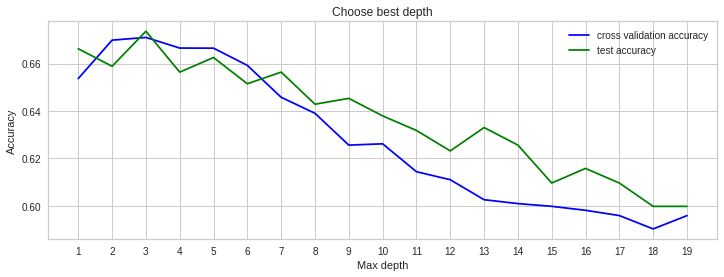

In [ ]:
depths = list(range(1, MAX_DEPTH))
plt.figure(figsize=(12,4))
plt.plot(depths, cv_history, label='cross validation accuracy', color='blue')
plt.plot(depths, test_history, label='test accuracy', color='green')

# Uncomment me if you want to see training errors
#plt.plot(depths, train_history, label='training accuracy', color='red')
plt.xticks(depths)
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.title('Choose best depth')
plt.legend()
plt.show()

In [ ]:
d=depths[np.argmax(test_history)]
clf = DecisionTreeClassifier(random_state=0, max_depth=d)
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

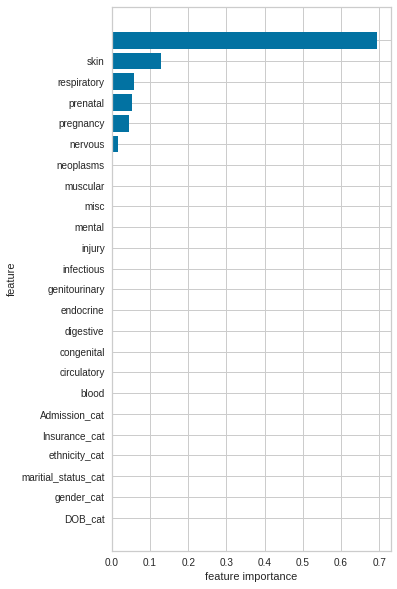

In [ ]:
sorted_features = sorted(zip(X_train, clf.feature_importances_), key= lambda couple: couple[1])
features, scores = zip(*sorted_features)
feature_names=['DOB_cat', 'gender_cat', 'maritial_status_cat', 'ethnicity_cat', 'Insurance_cat', 'Admission_cat',
               'blood', 'circulatory', 'congenital', 'digestive', 'endocrine', 'genitourinary', 'infectious', 'injury',
               'mental', 'misc', 'muscular', 'neoplasms', 'nervous', 'pregnancy', 'prenatal', 'respiratory', 'skin']

plt.figure(figsize=(5,10))
plt.barh(range(len(features)), scores, align='center')
plt.yticks(range(len(features)),feature_names)
plt.xlabel('feature importance')
plt.ylabel('feature')
plt.show()

## RandomForestClassifier

In [ ]:
training_history = []
test_history = [] 
NB_TREES = 200
for nb_trees in range(1, NB_TREES, 10):
    clf_rf = RandomForestClassifier(n_estimators=nb_trees) # We don't specifiy trees' max depth i.e all trees are
    #build until all nodes are pure
    clf_rf.fit(X_train,y_train)
    training_history.append(clf_rf.score(X_train,y_train))
    test_history.append(clf_rf.score(X_test, y_test))

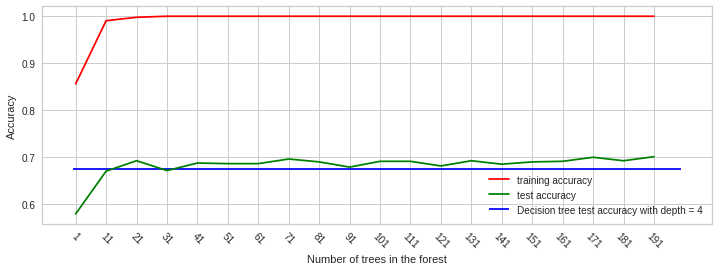

In [ ]:
nb_trees = list(range(1, NB_TREES, 10))
plt.figure(figsize=(12,4))
plt.plot(nb_trees, training_history, label='training accuracy', color='red')
plt.plot(nb_trees, test_history, label='test accuracy', color='green')
plt.hlines(y=clf.score(X_test, y_test), xmin=0, xmax=200, color='blue', label='Decision tree test accuracy with depth = 4')
plt.xticks(nb_trees, rotation=-45)
plt.xlabel('Number of trees in the forest')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
t=nb_trees[np.argmax(test_history)]
clf_rf = RandomForestClassifier(n_estimators=t)
clf_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=191,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## Logistic Regression

In [ ]:
model = LogisticRegression(solver='lbfgs')
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Naive Bayes Classifier

In [ ]:
nbc = BernoulliNB()
nbc.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

## Knn Classifier

In [ ]:
parameters = {'n_neighbors':[1,3,7],
             'p':[1,2]}

knn = KNeighborsClassifier()
clf_knn = GridSearchCV(knn, parameters, cv=3,n_jobs=-1)
clf_knn.fit(X_train,y_train)
clf_knn.best_params_

{'n_neighbors': 7, 'p': 1}

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 7,p=1)
knn.fit(X_train, y_train )

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=1,
                     weights='uniform')

### Support Vector Machine Classifier

In [ ]:
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['linear','rbf', 'sigmoid']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train) 

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.672, total=   0.1s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.672, total=   0.1s
[CV] C=0.1, gamma=1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.686, total=   0.1s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.678, total=   0.1s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.708, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.552, total=   0.2s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.552, total=   0.2s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.552, total=   0.2s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.552, total=   0.2s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .

[Parallel(n_jobs=1)]: Done 375 out of 375 | elapsed: 27.3min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['linear', 'rbf', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [ ]:
# print best parameter after tuning 
print(grid.best_params_) 

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


In [ ]:
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


### Gradient Boosting Classifier

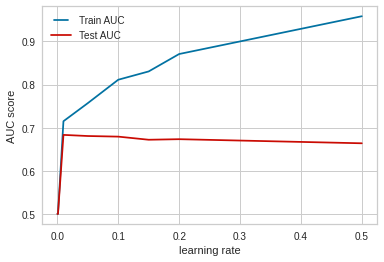

In [ ]:
learning_rates = [0.5,0.2,0.15,0.1, 0.05,0.01,0.001, 0.0001]
train_results = []
test_results = []
for eta in learning_rates:
   model = GradientBoostingClassifier(learning_rate=eta)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

line1, = plt.plot(learning_rates, train_results, 'b', label='Train AUC')
line2, = plt.plot(learning_rates, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('learning rate')
plt.show()

In [ ]:
lr=learning_rates[np.argmax(test_results)]
print("best learning rate is: ",lr)

best learning rate is:  0.01


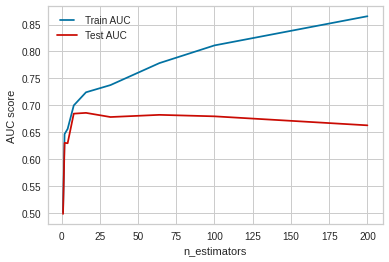

In [ ]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for estimator in n_estimators:
   model = GradientBoostingClassifier(n_estimators=estimator)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)


line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

In [ ]:
n_estimators=n_estimators[np.argmax(test_results)]
print("best n_estimators is: ",n_estimators)

best n_estimators is:  16


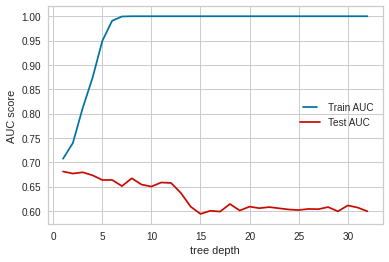

In [ ]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   model = GradientBoostingClassifier(max_depth=max_depth)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)


line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('tree depth')
plt.show()

In [ ]:
max_depths=max_depths[np.argmax(test_results)]
print("best tree depth is: ",max_depths)

best tree depth is:  1.0


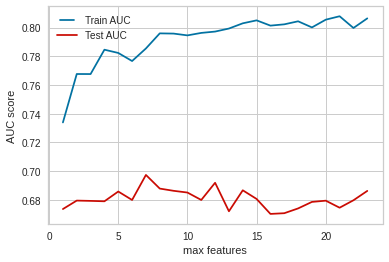

In [ ]:
max_features = list(range(1,X_train.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
   model = GradientBoostingClassifier(max_features=max_feature)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
 
 
line1, = plt.plot(max_features, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_features, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.show()

In [ ]:
max_features=max_features[np.argmax(test_results)]
print("best max features is: ",max_features)

best max features is:  7


In [ ]:
gbc = GradientBoostingClassifier(max_features=max_features,learning_rate=lr)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=3,
                           max_features=7, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

# Evaluation metrics

In [ ]:
print("logistic regression accuracy: ", model.score(X_test, y_test))
print("Decision Tree Classifier accuracy: ",clf.score(X_test, y_test))
print("Random Forest Classifier accuracy: ",clf_rf.score(X_test, y_test))
print("NAive Bayes Classifier accuracy: ",nbc.score(X_test, y_test))
print("Knn Classifier accuracy: ",clf_knn.score(X_test, y_test))
print("SVM Classifier accuracy: ",grid.score(X_test, y_test))

logistic regression accuracy:  0.7056650246305419
Decision Tree Classifier accuracy:  0.6736453201970444
Random Forest Classifier accuracy:  0.6798029556650246
NAive Bayes Classifier accuracy:  0.6637931034482759
Knn Classifier accuracy:  0.6477832512315271
SVM Classifier accuracy:  0.6761083743842364


In [ ]:
print("Gradient boosting Classifier accuracy: ",gbc.score(X_test, y_test))

Gradient boosting Classifier accuracy:  0.6834975369458128


# classification reports

In [ ]:
target_names = ['no re-admission', 're-admission']

y_model= model.predict(X_test)
y_clf= clf.predict(X_test)
y_clf_rf= clf_rf.predict(X_test)
y_nbc= nbc.predict(X_test)
y_clf_knn=clf_knn.predict(X_test)
y_svm=grid.predict(X_test)
y_gbc=gbc.predict(X_test)


In [ ]:
print("Logistic Regression Classification Report: \n"+ classification_report(y_test, y_model, target_names=target_names))
print("Model's MSE score: "+ str(mean_squared_error(y_test, y_model)))

Logistic Regression Classification Report: 
                 precision    recall  f1-score   support

no re-admission       0.68      0.68      0.68       371
   re-admission       0.73      0.73      0.73       441

       accuracy                           0.71       812
      macro avg       0.70      0.70      0.70       812
   weighted avg       0.71      0.71      0.71       812

Model's MSE score: 0.29433497536945813


In [ ]:
print("Decision Tree Classifier Classification Report: \n"+ classification_report(y_test, y_clf, target_names=target_names))
print("Model's MSE score: "+ str(mean_squared_error(y_test, y_clf)))

Decision Tree Classifier Classification Report: 
                 precision    recall  f1-score   support

no re-admission       0.63      0.69      0.66       371
   re-admission       0.72      0.66      0.69       441

       accuracy                           0.67       812
      macro avg       0.67      0.67      0.67       812
   weighted avg       0.68      0.67      0.67       812

Model's MSE score: 0.3263546798029557


In [ ]:
print("Random Forest Classifier Classification Report: \n"+ classification_report(y_test, y_clf_rf, target_names=target_names))
print("Model's MSE score: "+ str(mean_squared_error(y_test, y_clf_rf)))

Random Forest Classifier Classification Report: 
                 precision    recall  f1-score   support

no re-admission       0.67      0.59      0.63       371
   re-admission       0.69      0.75      0.72       441

       accuracy                           0.68       812
      macro avg       0.68      0.67      0.67       812
   weighted avg       0.68      0.68      0.68       812

Model's MSE score: 0.32142857142857145


In [ ]:
print("Knn Classifier Classification Report: \n"+ classification_report(y_test, y_clf_knn, target_names=target_names))
print("Model's MSE score: "+ str(mean_squared_error(y_test, y_clf_knn)))

Knn Classifier Classification Report: 
                 precision    recall  f1-score   support

no re-admission       0.60      0.70      0.65       371
   re-admission       0.71      0.60      0.65       441

       accuracy                           0.65       812
      macro avg       0.65      0.65      0.65       812
   weighted avg       0.66      0.65      0.65       812

Model's MSE score: 0.3522167487684729


In [ ]:
print("NAive Bayes Classifier Classification Report: \n"+ classification_report(y_test, y_nbc, target_names=target_names))
print("Model's MSE score: "+ str(mean_squared_error(y_test, y_nbc)))

NAive Bayes Classifier Classification Report: 
                 precision    recall  f1-score   support

no re-admission       0.62      0.68      0.65       371
   re-admission       0.71      0.65      0.68       441

       accuracy                           0.66       812
      macro avg       0.66      0.66      0.66       812
   weighted avg       0.67      0.66      0.66       812

Model's MSE score: 0.33620689655172414


In [ ]:
print("SVM Classifier Classification Report: \n"+ classification_report(y_test, y_svm, target_names=target_names))
print("SVM's MSE score: "+ str(mean_squared_error(y_test, y_svm)))

SVM Classifier Classification Report: 
                 precision    recall  f1-score   support

no re-admission       0.66      0.59      0.63       371
   re-admission       0.69      0.75      0.71       441

       accuracy                           0.68       812
      macro avg       0.67      0.67      0.67       812
   weighted avg       0.68      0.68      0.67       812

SVM's MSE score: 0.32389162561576357


In [ ]:
print("gradient boosting Classifier Classification Report: \n"+ classification_report(y_test, y_gbc, target_names=target_names))
print("GBC's MSE score: "+ str(mean_squared_error(y_test, y_gbc)))

gradient boosting Classifier Classification Report: 
                 precision    recall  f1-score   support

no re-admission       0.67      0.60      0.63       371
   re-admission       0.69      0.76      0.72       441

       accuracy                           0.68       812
      macro avg       0.68      0.68      0.68       812
   weighted avg       0.68      0.68      0.68       812

GBC's MSE score: 0.31650246305418717


# Confusion Matrices

Logistic Regression:  0.7056650246305419


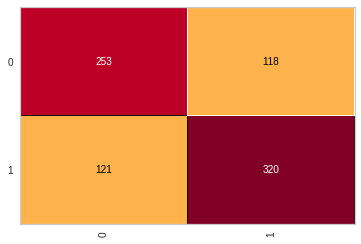

In [ ]:
viz = ConfusionMatrix(LogisticRegression(solver='lbfgs'))
viz.fit(X_train, y_train)
print("Logistic Regression: ", viz.score(X_test, y_test))

Decision Tree Classifier:  0.6736453201970444


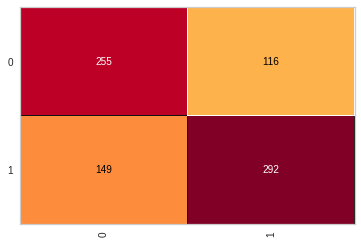

In [ ]:
viz = ConfusionMatrix(DecisionTreeClassifier(random_state=0, max_depth=d))
viz.fit(X_train, y_train)
print("Decision Tree Classifier: ", viz.score(X_test, y_test))

Random Forest Classifier:  0.6798029556650246


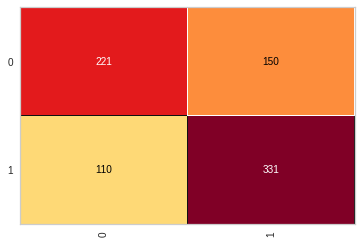

In [ ]:
viz = ConfusionMatrix(RandomForestClassifier(n_estimators=t))
viz.fit(X_train, y_train)
print("Random Forest Classifier: ", viz.score(X_test, y_test))

NAive Bayes Classifier:  0.6637931034482759


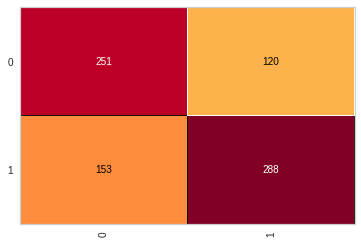

In [ ]:
viz = ConfusionMatrix(BernoulliNB())
viz.fit(X_train, y_train)
print("NAive Bayes Classifier: ", viz.score(X_test, y_test))

Knn Classifier:  0.6477832512315271


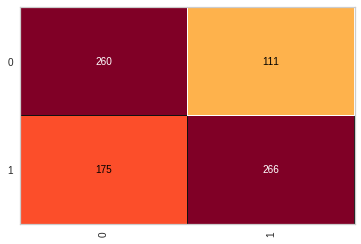

In [ ]:
viz = ConfusionMatrix(KNeighborsClassifier(n_neighbors = 7,p=1))
viz.fit(X_train, y_train)
print("Knn Classifier: ", viz.score(X_test, y_test))

SVM Classifier:  0.6761083743842364


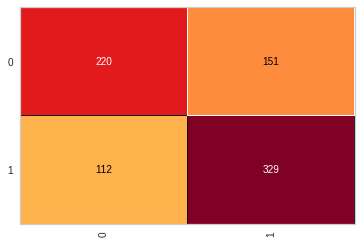

In [ ]:
viz = ConfusionMatrix(SVC(C= 1, gamma= 0.1, kernel= 'rbf'))
viz.fit(X_train, y_train)
print("SVM Classifier: ", viz.score(X_test, y_test))

gradient boosting Classifier:  0.6847290640394089


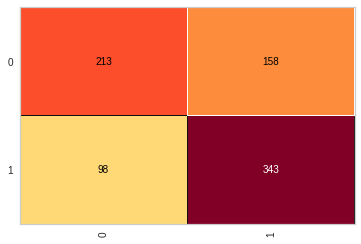

In [ ]:
viz = ConfusionMatrix(GradientBoostingClassifier(max_features=max_features,learning_rate=lr))
viz.fit(X_train, y_train)
print("gradient boosting Classifier: ", viz.score(X_test, y_test))

# In conclusion, we notice that the best model to predict patient re_admission was Logistic regression

1.   Logistic Regression(accuracy score: 0.7)
2.   Gradient boosting classifier(accuracy score: 0.684)
3.   Random forest classifier(accuracy score: 0.679)
4.   SVM classifier(accuracy score: 0.676)
5.   Decision Tree classifier(accuracy score: 0.673)
6.   Naive bayes classifier(accuracy score: 0.663)
7.   Knn classifier(accuracy score: 0.647)
